In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

In [2]:
# random variable generation for gamma distribution

def generate_gamma_dist(shape):
    dist_gamma = sorted(stats.gamma.rvs(shape, loc=0, scale=1000, size=5000))
    shape, loc, scale = stats.gamma.fit(dist_gamma, loc=0)
    pdf_gamma = stats.gamma.pdf(dist_gamma, shape, loc, scale)
    return dist_gamma, pdf_gamma

<IPython.core.display.Javascript object>


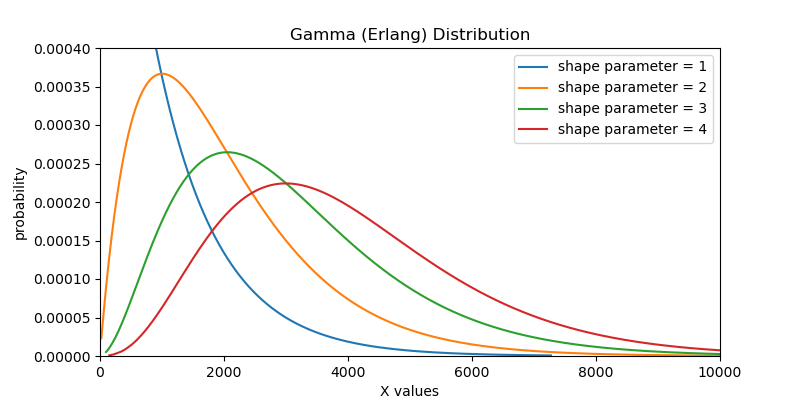

In [3]:
# visualize

fig, ax = plt.subplots(figsize=(8, 4))
for i in range(1, 5):
    x, y = generate_gamma_dist(i)
    ax.plot(x, y, label='shape parameter = %s' % i)
    
ax.set_xlabel('X values')
ax.set_ylabel('probability')
ax.set_ylim(0, 0.0004)
ax.set_xlim(0, 10000)
ax.set_title('Gamma (Erlang) Distribution')
ax.legend();

1. Data Preparation
We will use phone calls data from Enigma Public. Enigma Public is a website that processes & hosts various public data and allows people to obtain them through file downloads or API access. The sample data originally comes from the National Response Center (NRC). They receive phone calls from anyone witnessing an oil spill, chemical release or maritime security incident and record that data.

For your convenience, I already downloaded the sample data and hosted it on this website. You can access the sample data directly by importing the file through requests.

In [4]:
import requests
import io
import pandas as pd

In [5]:
base_url = 'https://aegis4048.github.io/downloads/notebooks/sample_data/'
filename = '08c32c03-9d88-42a9-b8a1-f493a644b919_NRCEventReporting-Calls-2010.csv'

data = requests.get(base_url + filename).content
df   = pd.read_csv(io.StringIO(data.decode('utf-8')))
df.head()

,seqnos,date_time_received,date_time_complete,calltype,responsible_company,responsible_org_type,responsible_city,responsible_state,responsible_zip,source,serialid
0,946479,2010-07-03T21:11:31+00:00,2010-07-03T21:19:57+00:00,INC,NaN,UNKNOWN,NaN,XX,NaN,TELEPHONE,15900
1,946480,2010-07-03T20:59:29+00:00,2010-07-03T21:16:22+00:00,INC,CHEVRON,PRIVATE ENTERPRISE,NaN,HI,NaN,WEB REPORT,15901
2,946481,2010-07-03T21:42:43+00:00,2010-07-03T21:53:07+00:00,INC,BP,PRIVATE ENTERPRISE,NaN,LA,NaN,TELEPHONE,15902
3,946482,2010-07-03T22:22:41+00:00,2010-07-03T22:34:07+00:00,INC,CHEVRON,PRIVATE ENTERPRISE,SAN LUIS OBISPO,CA,93401,TELEPHONE,15903
4,946483,2010-07-03T22:46:13+00:00,2010-07-03T22:50:24+00:00,INC,NaN,UNKNOWN,NaN,XX,NaN,TELEPHONE,15904


1.1. Sample Data Processing
Since we are interested in the time ellapsed for each phone call, the primary columns of our interest are date_time_received and date_time_complete. However, the raw data is not in a numerical format that can be directly plotted on histogram; we will need to parse & process the time data. I chose .iloc[11000: 12000, :] because it would take too long time to process all ~30,000 rows of the original data. The data is then sorted by the timestamp column.

Process DateTime

In [6]:
import datetime

In [7]:
def process_time(row):
    
    call_received = datetime.datetime.strptime(row['date_time_received'].split('+')[0], '%Y-%m-%dT%H:%M:%S')
    call_ended    = datetime.datetime.strptime(row['date_time_complete'].split('+')[0], '%Y-%m-%dT%H:%M:%S')
    
    time_ellapsed = call_ended - call_received

    row['Parsed Call Received'] = str(call_received)
    row['Parsed Call Ended'] = str(call_ended)
    row['Time Ellapsed'] = str(time_ellapsed)
    row['Time Ellapsed (minutes)'] = round(time_ellapsed.total_seconds() / 60, 1)

    return row


In [8]:
# df was defined above

parsed_df = df.iloc[11000: 12000, :].apply(process_time, axis=1).iloc[:, -4:]
parsed_df['Parsed Call Received'] = pd.to_datetime(parsed_df['Parsed Call Received'], format='%Y-%m-%d %H:%M:%S')
parsed_df['Parsed Call Ended'] = pd.to_datetime(parsed_df['Parsed Call Ended'], format='%Y-%m-%d %H:%M:%S')
parsed_df = parsed_df.sort_values(by = 'Parsed Call Received')
parsed_df.head()

,Parsed Call Received,Parsed Call Ended,Time Ellapsed,Time Ellapsed (minutes)
11000,2010-05-21 19:32:09,2010-05-21 19:43:35,0:11:26,11.4
11001,2010-05-21 19:54:40,2010-05-21 19:58:40,0:04:00,4.0
11002,2010-05-21 20:03:14,2010-05-21 20:09:11,0:05:57,6.0
11003,2010-05-21 20:04:26,2010-05-21 20:07:39,0:03:13,3.2
11004,2010-05-21 20:18:38,2010-05-21 20:27:45,0:09:07,9.1


Drop Duplicate Rows

The original data does not record the time to a precision of microseconds (2010-07-03T21:11:31+00:00). Due to the imprecision of the recorded data, there will be rows with duplicate date_time_received and date_time_complete. The data itself is not duplicate, but the data in datetime column is duplicate. Leaving them as they are and plotting them might mess up your plots.

Observe the change in the row number of the data frame. It's the indication that there are rows with the same date_time_received values.

In [9]:
parsed_df.shape

(1000, 4)

In [10]:
new_parsed_df = parsed_df.drop_duplicates(subset=['Parsed Call Received'], keep=False)
new_parsed_df.shape

(998, 4)

2. Transformatoin
It can be observed that the phone call duration data does not follow normal distribution.



In [11]:
time_duration_orig = new_parsed_df['Time Ellapsed (minutes)'].values

<IPython.core.display.Javascript object>


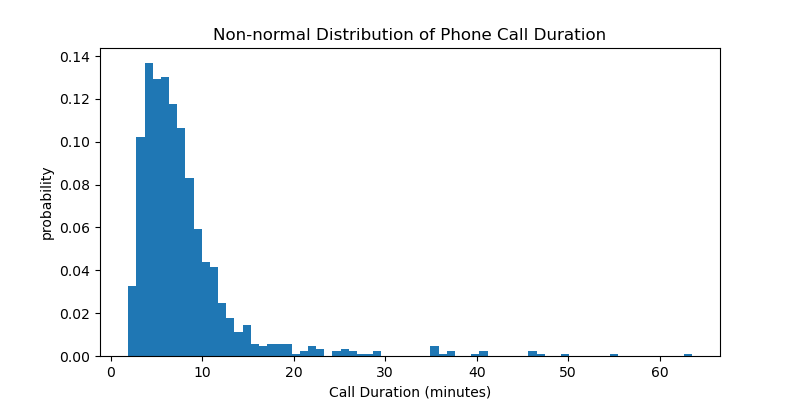

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(time_duration_orig, bins='auto', density=True)
ax.set_xlabel('Call Duration (minutes)')
ax.set_ylabel('probability')
ax.set_title('Non-normal Distribution of Phone Call Duration');

2.1. Box-Cox Transformation
The Python code implementation for Box-Cox is actually very simple. The below one-line code is it for transformation. More information about the Box-Cox function can be found in the scipy documentaion.

In [13]:
time_duration_trans, lmbda = stats.boxcox(time_duration_orig)

How does Box-Cox determine the best transformation parameter to obtain a distribution that is close to normal? It calculates correlation coefficient for different lambda (λ) values, and finds the one that maximizes the correlation coefficient. In our case, we find that the best lambda parameter is λ=−0.322

Best lambda parameter = -0.322


<IPython.core.display.Javascript object>


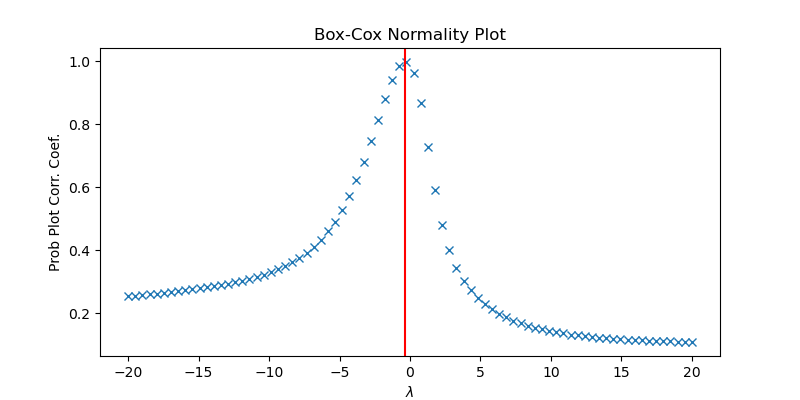

In [14]:
print('Best lambda parameter = %s' % round(lmbda, 3))

fig, ax = plt.subplots(figsize=(8, 4))
prob = stats.boxcox_normplot(time_duration_orig, -20, 20, plot=ax)
ax.axvline(lmbda, color='r');

2.2. Visual Inspection by Fitting Gaussian Distribution
One can visually inspect how good the transformation was by fitting a Gaussian distribution function.

In [15]:
# fit Gaussian distribution

time_duration_trans.sort()
mean, std = stats.norm.fit(time_duration_trans, loc=0)
pdf_norm = stats.norm.pdf(time_duration_trans, mean, std)

<IPython.core.display.Javascript object>


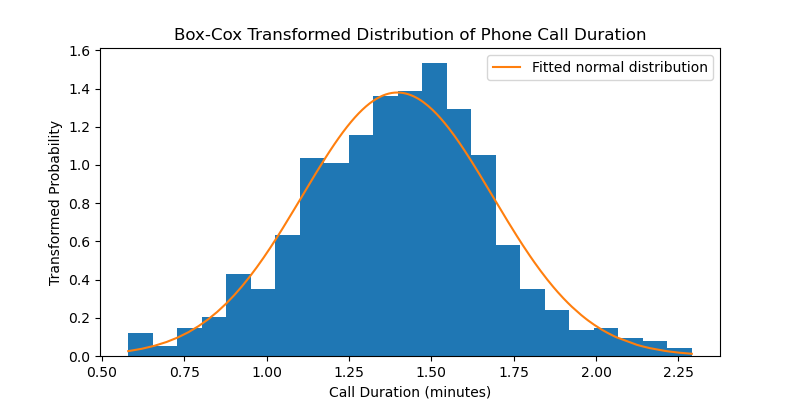

In [16]:
# visual inspection

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(time_duration_trans, bins='auto', density=True)
ax.plot(time_duration_trans, pdf_norm, label='Fitted normal distribution')
ax.set_xlabel('Call Duration (minutes)')
ax.set_ylabel('Transformed Probability')
ax.set_title('Box-Cox Transformed Distribution of Phone Call Duration')
ax.legend();

Based on the transformed historgram and the respective fitted normal distribuion, it seems that our Box-Cox transformation with λ=−0.322 worked well.

2.3. Visual Inspection with Q-Q Plots
Visual inspection can be done in a different way with Q-Q plots. The red straight line is the fitted theoretical Gaussian distribution function. If the scatter plot is closer to the red straight line, it means that the data is very close to Gaussian distribution. Deviation from the red line indicates that the data is most likely not Gaussian.

Recall that time_duration_orig is the original sample data, and time_duration_trans is the Box-Cox transformed data.

<IPython.core.display.Javascript object>


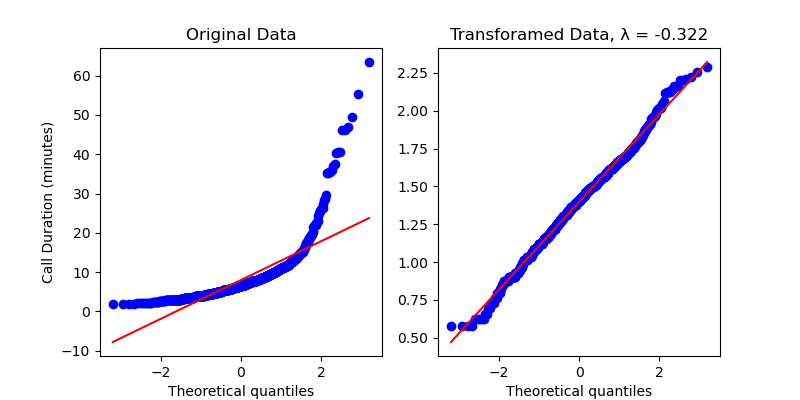

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

prob = stats.probplot(time_duration_orig, dist=stats.norm, plot=ax1)
prob = stats.probplot(time_duration_trans, dist=stats.norm, plot=ax2)

ax1.set_title('Original Data')
ax1.set_ylabel('Call Duration (minutes)')
ax2.set_title('Transforamed Data, λ = %s' % -0.322);
ax2.set_ylabel('');

No significant deviation is observed in Q-Q plots for the transformed data. The transformed data seems to follow Gaussian distribution well.

